# Определение стоимости авто по VIN-коду

## Описание проекта

Задача обработки текстового файла, содержащего VIN-коды машин Ford, нужно извлечь из этих данных необходимые признаки и использовать для обучения модели.
По итогу нужно получить предсказания цен автомобилей на основе информации, содержащейся в их уникальных идентификаторах - VIN-кодах.

**Цель проекта:** предсказание цены автомобиля по VIN-коду

**Метрика:** Оценка качества модели будет производиться с использованием метрик **RMSE**/**MAPE**

### Исходные данные

**vin_ford_train.txt** - текстовый файл, в котором содержится информация по **VIN**-кодам автомобилей и соответствующим ценам.
Необходимо с помощью регулярных выражений распарсить файл, не используя готовые модули для декодирования VIN-кодов, 
и получить из него данные, на основе которых нужно обучить модель


### Форматы VIN

<img src='photo_2024-04-22 15.25.28.jpeg'>

Номер состоит как из букв, так и из цифр. В качестве символов VIN могут использоваться заглавные буквы от **A** до **Z** и цифры от **1** до **0**; однако буквы **I**, **O** и **Q** никогда не используются, чтобы избежать ошибок при неправильном прочтении. В VIN не допускается использование знаков или пробелов. Нет двух одинаковых VIN-кодов.

**VIN 17 занков:**
- 1-3 - производитель
- 4 - ремни, тормоза, грузоподъемность у траков
- 5-7 - модель
- 8 - двигатель
- 9 - контрольный знак
- 10 - год
- 11 - завод произвадитель
- 12-17 - серийный номер

### План реализации:

1. Загрузка необходимых библиотек и данных
2. Изучение формата данных
3. Составление регулярных выражения для выделения цены, VIN-кодов и компонентов
4. Создание на основе полученных данных датасета 
5. Изучение данных - EDA
6. Подготовка тренировочного набора данных
7. Обучение и тестирование


# Загрузка необходимых библиотек и данных

### Импорт библиотек

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import re

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import phik


from sklearn.model_selection import (
    cross_val_score,
    cross_val_predict,
    train_test_split
)
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (GradientBoostingRegressor,  
                              RandomForestRegressor)

from sklearn.linear_model import Ridge
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor

### Параметры отображения

In [3]:
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)

### Значения констант

In [4]:
RANDOM_STATE = 654321
TEST_SIZE = .25

### Чтение файла с данными

In [5]:
with open('vin_ford_train.txt', 'r') as f:
    content = f.read()

In [6]:
content[:1000]

'[2FMDK3JC4BBA41556:12500]мой[3FA6P0H75ER208976:14500]дядя [3FAHP08Z17R268380:1300][1FMCU0GX3DUC59421:15200]самых [1FAHP2E89DG119368:11600] верных[1FM5K8D82DGA16143:26400][1FTFW1CFXCFC23663:14000][2FMDK3JC6CBA90002:19500][1FTFW1CT8DKD06233:24400][1FMZU64W13UC28949:2900][2FMDK3JC9DBB30736:23500][1FMCU9D76CKC49193:12700][1FMCU9EG2CKA90624:20700][1FMCU0JX7EUA28208:21300][2FMGK5D85EBD31213:26700][2FMDK4KC6EBA72011:25100]правил [1FTFX1EF2EKE24350:26700][1ZVBP8EM0D5237253:11600][1FDNE1BW5BDA64735:13200][3FA6P0H7XDR195494:11100][1FAHP2KT4CG139177:17300][1FMJK1J56EEF49240:36300][1FAHP2DW7AG112768:8200][1FAHP26185G158164:3800][1FTPX12584NB89868:2800][1FMCU9G90DUB02595:14400][3FAHP0HG8BR214825:8100][1ZVFT82H255209881:8000][1FTMF1CM2DKD84474:13200][1FMCU9G98DUC73580:17600][3FAHP0HA8BR154833:9900][1FTNE2EW3EDA30898:19600][1FTNF1CF3EKD47747:19000][1FM5K8D85DGA21918:18501][3FAHP0GA0AR351740:7200][1FMCU0D76CKA12182:14700][1FADP3F23EL151448:10100][1FAHP3FN2AW295660:6800][1FTRW14849FA35954:17900][3FA6P

**Итог:**

Строка состоит из **VIN**-кода, первые 17 знаков разделенные **:** цена. В данных помимо **VIN**-ов есть лишние значения между данными.
Далее нужно сделать шаблон в соответствии с Американским **VIN** форматом и преобразовать текстовый файл в формат **DataFrame**

# Парсинг

## Функции

In [7]:
def decode_vin(s: str):
    """
    Функция для декодирования VIN-кодов и извлечения информации

    Args:
    s (str): Строка, содержащая VIN-номера и соответствующие им цены
    
    Returns:
    DataFrame: DataFrame, содержащий информацию о декодированных VIN-номерах.
    """
    
    vin_re = re.compile(data_re)
    df = pd.DataFrame([x.groupdict() for x in vin_re.finditer(s)])
    return df

In [8]:
def data_review(data):
    """
    Функция для обзора данных.

    Функция выводит общую информацию о данных: обнаруженные пропуски, их процентное соотношение по каждому столбцу,
    общее количество пропущенных значений, количество явных дубликатов и основные статистические характеристики данных.

    Args:
    data (DataFrame): Данные для анализа в формате DataFrame.

    Returns:
    None. Функция выводит информацию на экран.
    """

    print('\033[1m \nОбщая информация: \n\033[0m \n')
    data.info()
    display(data.head(5))

    print('\n\033[1m Пропуски в данных: \033[0m \n')
    missing_percentage = (data.isna().sum() / len(data)) * 100
    display(pd.DataFrame({'Пропуски': data.isna().sum(), 'Процент пропусков': missing_percentage}))

    print('\n\033[1m Всего пропущенных значений: \033[0m', data.isna().sum().sum())
    print('\n\033[1m Количество явных дублей: \033[0m', data.duplicated().sum())
    
    print('\n\033[1m Основные статистические характеристики данных: \033[0m')
    display(data.describe().T)


## Разрешенные символы

VIN состоит из заглавных латинских букв и цифр, кроме **I**, **O** и **Q**, а также причих знаков или пробелов

In [9]:
# Отбираем букувы, кроме I, O, Q
CHARS = [chr(x) for x in range(ord('A'), ord('Z')+1) if chr(x) not in ('I', 'O', 'Q')]

# Отбираем цифры 1-9 и 0
NUMS = [str(x) for x in range(1, 10)] + ['0']

ALLOWED = ''.join(CHARS + NUMS)

In [10]:
ALLOWED

'ABCDEFGHJKLMNPRSTUVWXYZ1234567890'

Список разрешенных символов - есть 

## American VIN format 

**VIN 17 занков:**
- 1-3 - производитель
- 4 - ремни, тормоза, грузоподъемность у траков
- 5-7 - модель
- 8 - двигатель
- 9 - контрольный знак
- 10 - год
- 11 - завод произвадитель
- 12-17 - серийный номер

Что бы сделать код более читабельным, будем использовать `f` строки вместо `r`. Подготовим шаблон в соответствии с используемым VIN форматом:

In [11]:
manufacturer_re = f'(?P<manufacturer>[{ALLOWED}]{{3}})'                  # 1-3 - производитель
restraint_re = f'(?P<restraint>[{ALLOWED}])'                             # 4 - ремни, тормоза, грузоподъемность у траков
model_re = f'(?P<model>[{ALLOWED}]{{3}})'                                # 5-7 - модель
engine_re = f'(?P<engine>[{ALLOWED}])'                                   # 8 - двигатель
check_re = f'(?P<check>[{ALLOWED}])'                                     # 9 - контрольный знак
year_re = f'(?P<year>[{ALLOWED.replace("U", "").replace("Z", "")}])'     # 10 - год
plant_re = f'(?P<plant>[{ALLOWED}])'                                     # 11 - завод произвадитель
serial_num_re = f'(?P<serial_num>[{ALLOWED}]{{3}}\\d{{3}})'              # 12-17 - серийный номер

In [12]:
# Шаблон
vin_re = f'{manufacturer_re}{restraint_re}{model_re}{engine_re}{check_re}{year_re}{plant_re}{serial_num_re}'

# Цена авто
price_re = r'(?P<price>\d+)'

Далее нужно скомпилировать полученный шаблон в объект регулярного выражения:

In [13]:
data_re = re.compile(f'\[(?P<vin>{vin_re}):{price_re}\]')

In [14]:
data_re 

re.compile(r'\[(?P<vin>(?P<manufacturer>[ABCDEFGHJKLMNPRSTUVWXYZ1234567890]{3})(?P<restraint>[ABCDEFGHJKLMNPRSTUVWXYZ1234567890])(?P<model>[ABCDEFGHJKLMNPRSTUVWXYZ1234567890]{3})(?P<engine>[ABCDEFGHJKLMNPRSTUVWXYZ1234567890])(?P<check>[ABCDEFGHJKLMNPRSTUVWXYZ1234567890])(?P<year>[ABCDEFGHJKLMNPRSTVWXY1234567890])(?P<plant>[ABCDEFGHJKLMNPRSTUVWXYZ1234567890])(?P<serial_num>[ABCDEFGHJKLMNPRSTUVWXYZ1234567890]{3}\d{3})):(?P<price>\d+)\]',
           re.UNICODE)

Посмотрим на **итоговый** формат 

In [15]:
value = []

try:
    for i in data_re.finditer(content):
        value.append(i.groupdict())
except Exception as e:
    print(f"An error occurred: {e}")

value[:2]

[{'vin': '2FMDK3JC4BBA41556',
  'manufacturer': '2FM',
  'restraint': 'D',
  'model': 'K3J',
  'engine': 'C',
  'check': '4',
  'year': 'B',
  'plant': 'B',
  'serial_num': 'A41556',
  'price': '12500'},
 {'vin': '3FA6P0H75ER208976',
  'manufacturer': '3FA',
  'restraint': '6',
  'model': 'P0H',
  'engine': '7',
  'check': '5',
  'year': 'E',
  'plant': 'R',
  'serial_num': '208976',
  'price': '14500'}]

По итогу имеем список словарей. Каждый элемент списка представляет отдельную запись данных, а каждый словарь содержит пары ключ-значение, где ключи - это названия столбцов данных ('vin', 'manufacturer', и т.д.), а значения - соответствующие значения для каждой записи данных ('2FMDK3JC4BBA41556', '2FM', и т.д.).

## DataFrame

Воспользуемся функцией для декодирования VIN-кодов и изучим информацию

In [16]:
# Получаем DataFrame
df = decode_vin(content)

In [17]:
data_review(df)

 
Общая информация: 
 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71884 entries, 0 to 71883
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   vin           71884 non-null  object
 1   manufacturer  71884 non-null  object
 2   restraint     71884 non-null  object
 3   model         71884 non-null  object
 4   engine        71884 non-null  object
 5   check         71884 non-null  object
 6   year          71884 non-null  object
 7   plant         71884 non-null  object
 8   serial_num    71884 non-null  object
 9   price         71884 non-null  object
dtypes: object(10)
memory usage: 5.5+ MB


,vin,manufacturer,restraint,model,engine,check,year,plant,serial_num,price
0,2FMDK3JC4BBA41556,2FM,D,K3J,C,4,B,B,A41556,12500
1,3FA6P0H75ER208976,3FA,6,P0H,7,5,E,R,208976,14500
2,3FAHP08Z17R268380,3FA,H,P08,Z,1,7,R,268380,1300
3,1FMCU0GX3DUC59421,1FM,C,U0G,X,3,D,U,C59421,15200
4,1FAHP2E89DG119368,1FA,H,P2E,8,9,D,G,119368,11600



 Пропуски в данных:  



,Пропуски,Процент пропусков
vin,0,0.00
manufacturer,0,0.00
restraint,0,0.00
model,0,0.00
engine,0,0.00
check,0,0.00
year,0,0.00
plant,0,0.00
serial_num,0,0.00
price,0,0.00



 Всего пропущенных значений:  0

 Количество явных дублей:  0

 Основные статистические характеристики данных: 


,count,unique,top,freq
vin,71884,71884,1FMCU9D78AKD21749,1
manufacturer,71884,14,1FM,18347
restraint,71884,26,D,12370
model,71884,365,P0H,6171
engine,71884,32,2,7015
check,71884,11,1,6622
year,71884,25,D,17286
plant,71884,21,R,10535
serial_num,71884,68215,B55197,4
price,71884,643,11000,574


Всего 71 885 сток кода на 10 признаков

В данныех нет пропусков, нет выбиваеющихся/редких значений, нет дублей, все признаки в формате object

Из основных статистических характеристик данных можно сделать следующие выводы:

1. Производитель (manufacturer) имеет 14 уникальных значений, причем наиболее часто встречающийся производитель - "1FM", который встречается 18 348 раз.
2. Наиболее часто встречающееся значение для ограничений (restraint) - "D", встречается 12 370 раз.
3. Существует 365 уникальных моделей (model), и наиболее часто встречающаяся модель - "P0H", которая встречается 6 171 раз.
4. Вид двигателя (engine) имеет 32 уникальных значений, при этом наиболее часто встречающийся вид - "2", встречается 7 015 раз.
5. Проверка (check) имеет 11 уникальных значений, и наиболее частое значение - "1", встречается 6 622 раза.
6. Год выпуска (year) представлен 25 уникальными значениями. Наиболее часто встречающееся значение - "D", встречается 17 287 раз.
7. Завод (plant) имеет 21 уникальное значение, и наиболее часто встречающийся завод - "R", встречается 10 535 раз.
8. Серийный номер (serial_num) имеет 68 216 уникальных значений, и наиболее часто встречающийся серийный номер - "B55197", который встречается 4 раза.
9. Цены (price) имеют 643 уникальных значения. Наиболее часто встречающееся значение - 11 000

## Итог

На **этапе парсинга** VIN кодов отобраны разрешенные символы, на основе которых был сгенерирован шаблон для **ford**, соответствующий **американскому VIN формату**. Дальше уже, полученный шаблон, скомпилирован в объект регулярного выражения, с помощью которого была реализована функция для преобразования текстового файла в формат **DataFrame**.

В данныех **не вывлено**:
- пропусков
- выбиваеющихся/редких значений
- явных дублей

Формат данных: **object**

**Итоговые признаки:**

- **vin** - полная VIN запись
- **manufacturer** - производитель
- **restraint** - ремни, тормоза, грузоподъемность у траков
- **model** - модель
- **engine** - двигатель
- **check** - контрольный знак
- **year** - год
- **plant** - завод произвадитель
- **serial** - серийный номер
- **price** - цена авто

# Предварительная обработка данных

После разложения номера VIN на отдельные компоненты (производитель, модель, год и т.д.) информация о VIN становится избыточной, поскольку все необходимые сведения уже представлены в отдельных признаках, сам столбец можно удалять.

In [18]:
# Удаление признаков
df.drop(columns=['vin'], inplace=True)

Признаки в DataFrame хранят ти данных **object**, но не все столбцы соответсвуют этому типу:

In [19]:
# Преобразование данных в нужный формат
df['price'] = df['price'].astype(int)

In [20]:
df.head()

,manufacturer,restraint,model,engine,check,year,plant,serial_num,price
0,2FM,D,K3J,C,4,B,B,A41556,12500
1,3FA,6,P0H,7,5,E,R,208976,14500
2,3FA,H,P08,Z,1,7,R,268380,1300
3,1FM,C,U0G,X,3,D,U,C59421,15200
4,1FA,H,P2E,8,9,D,G,119368,11600


**Итоговые признаки:**

- **manufacturer** - производитель
- **restraint** - ремни, тормоза, грузоподъемность у траков
- **model** - модель
- **engine** - двигатель
- **check** - контрольный знак
- **year** - год
- **plant** - завод произвадитель
- **serial** - серийный номер
- **price** - цена авто

# EDA

## Функции 

In [21]:
def plot_price_distribution(df):
    """
    Строит гистограмму распределения цен.

    Args:
    - df : pandas.DataFrame
        Датафрейм, содержащий данные для анализа.

    Returns:
    None. Функция выводит информацию на экран.
    """
    plt.figure(figsize=(12, 5))
    sns.histplot(data=df, x='price', kde=True)
    plt.title('Распределение цен (target)', fontsize=16)
    plt.xlabel('Price', fontsize=16)
    plt.ylabel('Count', fontsize=16)
    plt.show()


In [22]:
def plot_categorical_feature(df, categorical_feature):
    """
    Строит график, показывающий среднюю цену или ее распределение 
    в зависимости от категориального признака. 
    Если количество уникальных значений признака менее 30, 
    функция строит ящик с усами (boxplot), 
    показывающий распределение цен для каждой категории. 
    Если уникальных значений более 30, функция строит 
    столбчатую диаграмму, отображающую среднюю цену для каждой категории.

    Args:
    - df : pandas.DataFrame
        Датафрейм, содержащий данные для анализа.
    - categorical_feature : str
        Название категориального признака, для которого нужно построить график.

    Returns:
    None. Функция выводит информацию на экран.
    """
    plt.figure(figsize=(15, 6))
    if df[categorical_feature].nunique() < 30:
        sns.boxplot(x=categorical_feature, y='price', data=df)
        plt.title(f'Boxplot цены от {categorical_feature}', fontsize=16)
    else:
        sns.barplot(x=categorical_feature, y='price', data=df, estimator=lambda x: sum(x) / len(x))
        plt.title(f'Средняя цена от {categorical_feature}', fontsize=16)
        
    plt.xlabel(categorical_feature, fontsize=16)
    plt.ylabel('Price', fontsize=16)
    plt.xticks(rotation=45)
    plt.show()


In [23]:
def model_barplot(df, n=10):
    """
    Построение столбчатой диаграммы для наиболее дорогих и наименее дорогих моделей,
    отображающей среднюю цену для каждой категории.

    Параметры:
    - df : pandas.DataFrame
        Датафрейм, содержащий данные.
    - n : int, optional
        Количество моделей для отображения. По умолчанию 10.

    Возвращает:
    None
    """
    # Получение списка уникальных моделей и сортировка по цене
    unique_models = df.groupby('model')['price'].mean().sort_values(ascending=False)

    # Получение списка наиболее дорогих и наименее дорогих моделей
    top_models = unique_models.head(n)
    bottom_models = unique_models.tail(n)

    # Создание датафреймов 
    top_df = df[df['model'].isin(top_models.index)]
    bottom_df = df[df['model'].isin(bottom_models.index)]

    # Задание стиля и цветовой палитры
    sns.set_style("whitegrid")
    colors = sns.color_palette("viridis", n)

    # Построение столбчатой диаграммы для наиболее дорогих моделей
    plt.figure(figsize=(12, 5))
    sns.barplot(x='model', y='price', data=top_df, palette=colors, alpha=.8)
    plt.title('Средняя цена для наиболее дорогих моделей', fontsize=16)
    plt.xlabel('Модель')
    plt.ylabel('Средняя цена')
    plt.xticks(rotation=45)
    plt.show()

    # Построение столбчатой диаграммы для наименее дорогих моделей
    plt.figure(figsize=(12, 5))
    sns.barplot(x='model', y='price', data=bottom_df, palette=colors, alpha=.8)
    plt.title('Средняя цена для наименее дорогих моделей', fontsize=16)
    plt.xlabel('Модель')
    plt.ylabel('Средняя цена')
    plt.xticks(rotation=45)
    plt.show()

## Обзор данных

Построим график распределения цен и подробнее изучим данные

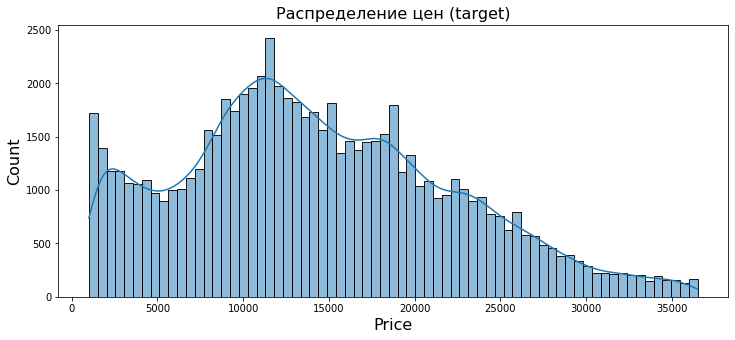

In [24]:
plot_price_distribution(df)

In [25]:
df['price'].describe()

count   71884.00
mean    14321.45
std      7827.06
min      1000.00
25%      8800.00
50%     13500.00
75%     19500.00
max     36500.00
Name: price, dtype: float64

График положительно скошенный:
- **среднее** значение (14 321) больше **медианы** (13 500)
- **макисмум** достигется на отметке 36500 **минимум** 1 000
- **стандартное отклонение** 7 827

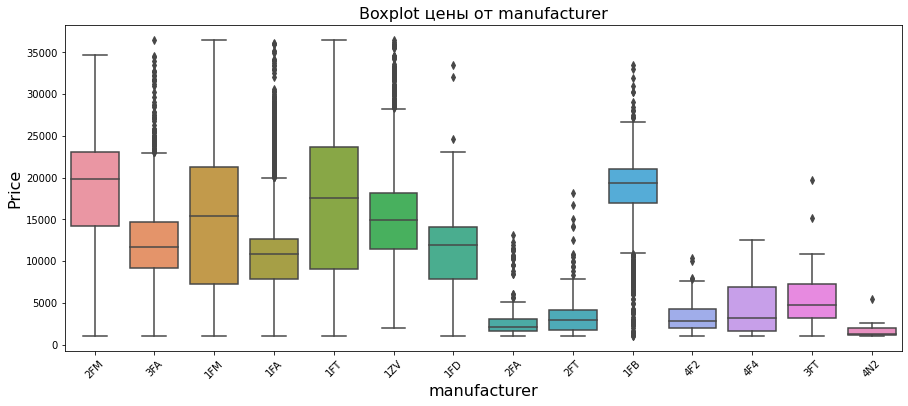

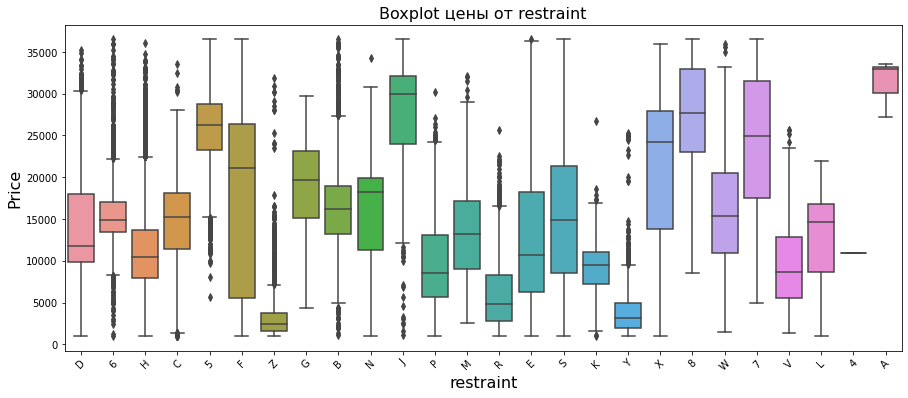

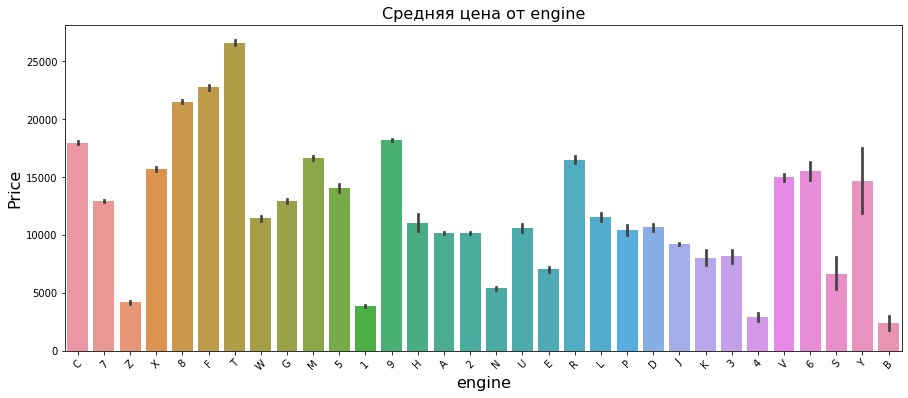

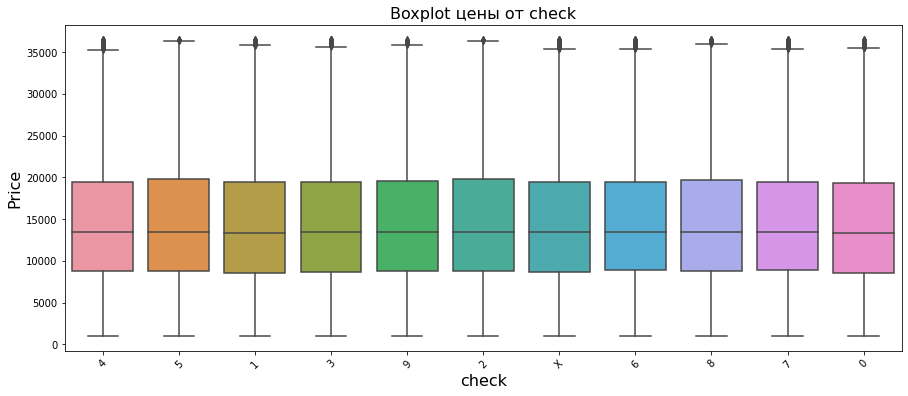

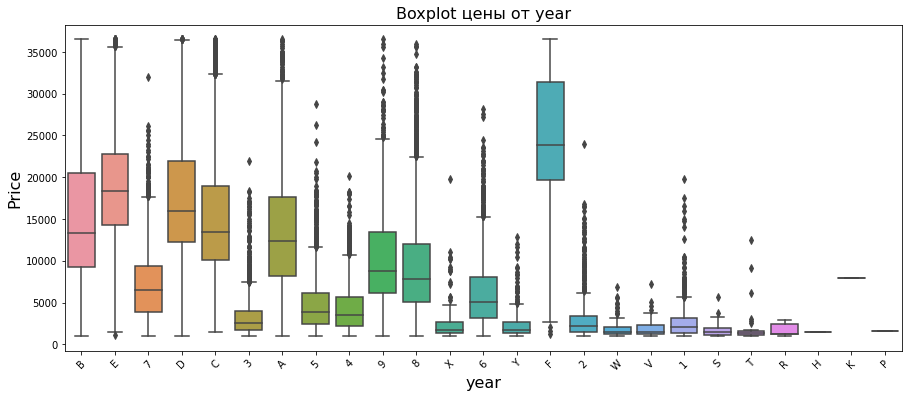

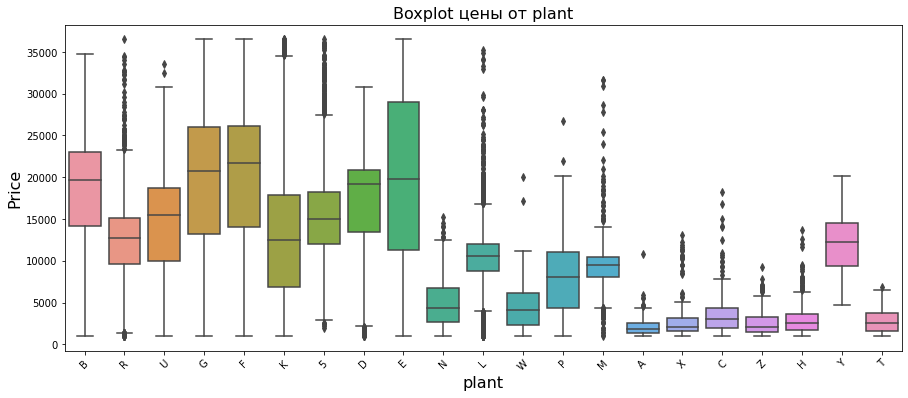

In [26]:
# Построение графика для категориальных признаквов
categorical_features = ['manufacturer', 'restraint', 'engine', 'check', 'year', 'plant']

for feature in categorical_features:
    plot_categorical_feature(df, feature)


На ящиках с усами видны редкие значения для некоторых из признаков, если смотреть на картину целеком, могу предположить что данные находятся в пределах нормы.

На график выше не попал признак `model`, так как он хранит 365 уникальных значений, для наглядности изучим по **10** моделей у которых самое **высокое** и **низкое** **среднее** значение по прайсу:

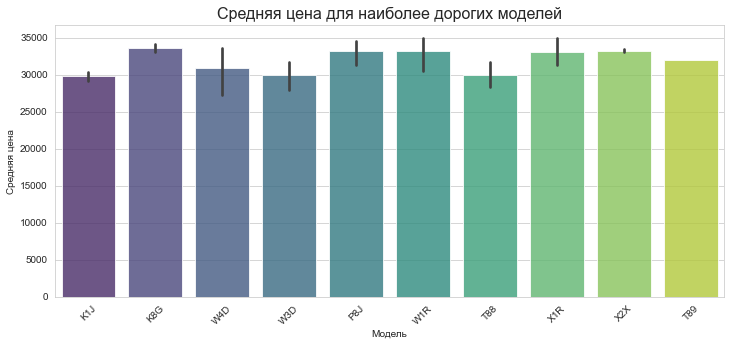

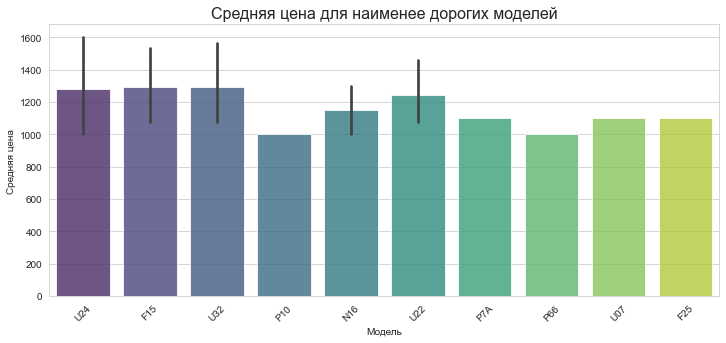

In [27]:
model_barplot(df)

**Наибольшее среднее** значение по прайсу у моделей: 
- P8J
- W1R
- X1R
  
Цена на эти модели находятся у отметки 36 000/35 000

**Наименьшее среднее** значение по прайсу у моделей: 
- P10
- P66
Цена на эти модели находятся у отметки 1000

interval columns not set, guessing: ['price']


<function matplotlib.pyplot.show(close=None, block=None)>

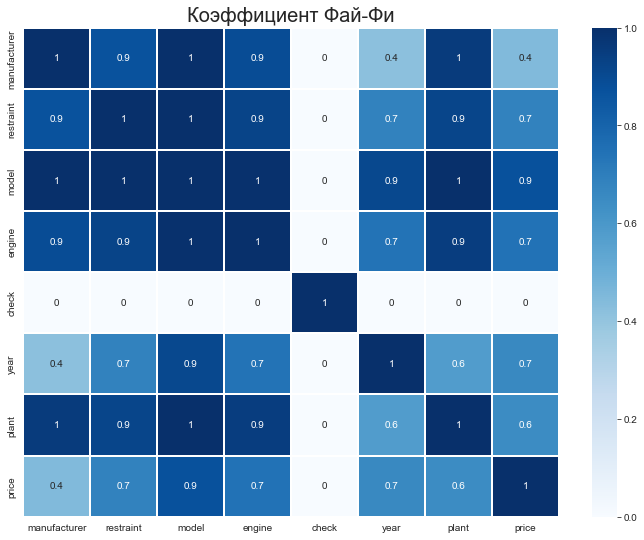

In [28]:
# Матрица корреляции

plt.figure(figsize=(12, 9))
plt.title('Коэффициент Фай-Фи', fontsize=20)
sns.heatmap(df.drop(columns='serial_num').phik_matrix(), annot=True, 
            fmt='.1g', linewidths=2, cmap='Blues')
plt.show

Фичи сильно коррелируют между собой, что приводит к проблеме мультиколлинеарности.
Подходы для избежания проблем:
- Удаление коррелирующих фичей
- Использование методов регуляризации L1 и/или L2
- Использование алгоритмов, устойчивых к мультиколлинеарности
- Кросс-валидация

У признака `check` нулевая корреляция с таргетом, но удалять его пока не будем, 
так как корреляция не всегда отражает взаимосвязь, будем смотреть по важности признаков

In [29]:
# Удаление признаков
df.drop(columns=['check', 'serial_num', 'model'], inplace=True)

На этом этапе попробуем удалить наиболее сильно коррелирующийся признак с таргетом `model`. Во время обучения будут применены вышеперечисленные подходы  

*Контрольный знак (check) оказался не эффективен, это было видно на графике важности признаков*
**(serial_num)* ухудшает метрику. Признаки были удалены уже после первого обучения, это решение улучшило метрику*

*Попробовала прогнать модели с использованием признака `mode`, как и предполагалось - привело к переобучению*

## Итог

По заключению исследовательского анализа можно сделать вывод о том что:
- Распределение цен близко к нармальному распределению
- Данные находятся в пределах нормы
  
**Коэффициент Фай-Фи** показывает сильную корреляцию фичей как с таргетом так и между собой. На основании сильной корреляцию, достигшей отметки .9, признак `model` не попал в итоговую выборку. Для избежания неготивных последствий мультиколлениарности, будут приняты меры уже в процессе обучения


**Итоговые признаки:**

- **manufacturer** - производитель
- **restraint** - ремни, тормоза, грузоподъемность у траков
- **engine** - двигатель
- **year** - год
- **plant** - завод произвадитель
- **price** - цена авто

# Обучение моделей

## Подготовка данных

In [30]:
X = df.drop('price', axis=1)
y = df['price']

In [31]:
# Разделяем данные на train и test
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=TEST_SIZE,
                                                    random_state=RANDOM_STATE)

print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(53913, 5)
(17971, 5)
(53913,)
(17971,)


Данные нужно закодировать, использование OHE, и подобных кодировщиков которые генерируют доп признаки, может привести к мультиколлинеарности, в рамках этой задачи будем использовать  OrdinalEncoder. Каждое уникальное значение преобразуется в целочисленное, таким образом, все значения просто преобразовываются в числовой ряд по возрастанию. И стандартизируем данные перед обучением, будет не лишним 

In [32]:
categorical = X_train.columns

In [33]:
#Создадим объект этой структуры и настроим его на обучающих данных
ordinal_encoder = OrdinalEncoder()

In [34]:
#Сохраним проеобразование для тренировочный выборки 
X_train[categorical] = ordinal_encoder.fit_transform(X_train[categorical])

In [35]:
#Сохраним проеобразование для тестовой выборки 
X_test[categorical] = ordinal_encoder.fit_transform(X_test[categorical])

In [36]:
X_train.head()

,manufacturer,restraint,engine,year,plant
63392,5.00,6.00,20.00,13.00,0.00
16408,9.00,2.00,6.00,12.00,14.00
25294,3.00,10.00,4.00,6.00,10.00
34758,7.00,8.00,11.00,13.00,2.00
50454,4.00,18.00,27.00,8.00,9.00


## Функции

In [37]:
# Важность признаков
def feature_importance(model, X, cv=5):
    importances = model['regressor'].feature_importances_
    df = pd.DataFrame(
        {'Feature': X.columns, 'Importance': importances}
                     ).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(8, 7))
    sns.barplot(x='Importance', y='Feature', data=df, palette='Blues')
    plt.title('Feature Importance', fontsize=16)
    plt.show()

In [38]:
# Препроцессор
preprocessor = ColumnTransformer(
    [   
        ('standard_scaler', StandardScaler(), X_train.columns)
    ],
    remainder="passthrough"
)

## Обучение моделей

*Выбор между L1 и L2 регуляризацией: если важно отобрать наиболее важные фичи и уменьшить размерность данных, то лучше использовать L1 регуляризацию. Если важно улучшить обобщающую способность модели и уменьшить влияние мультиколлинеарности, то лучше использовать L2 регуляризацию. В некоторых случаях также можно комбинировать оба метода в одной модели (**Elastic Net регуляризация**), чтобы получить наилучший результат.*

P.S. Использование GridSearchCV с перебором параметров оказалось не эффективным, приводило к сильному переобучению. 
Задание метрик вручную приводило к ухудшению метрики 

### DecisionTreeRegressor

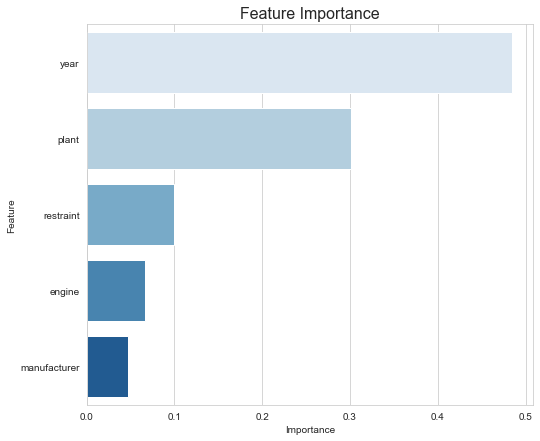

Average score: 3067.51
CPU times: user 1.15 s, sys: 173 ms, total: 1.32 s
Wall time: 1.05 s


In [39]:
%%time
pipeline_dtc = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor())
])

# Оценка качества модели с кросс-валидацией
scores_dtc = cross_val_score(pipeline_dtc, 
                         X_train, y_train, 
                         cv=5, 
                         scoring='neg_root_mean_squared_error')

pipeline_dtc.fit(X_train, y_train)

# Важность признаков
feature_importance(pipeline_dtc, X_train)
print(f'Average score: {-scores_dtc.mean():.2f}')

Топ-3 признака для **DecisionTree**:
- год
- завод производитель
- ремни, тормоза, грузоподъемность у траков

*Контрольный знак (check) оказался не важен для этой модели. Находится ниже отметки .1 и стремится к 0*

### RandomForestRegressor

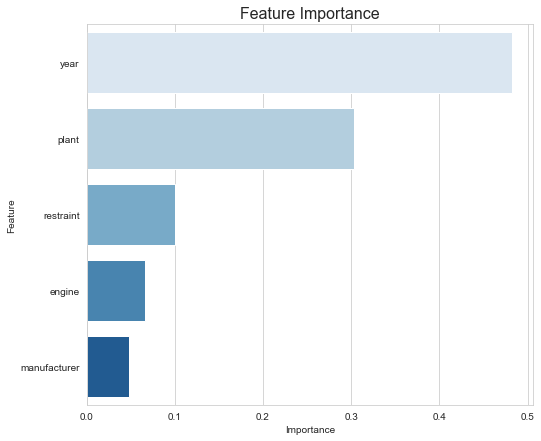

Average score: 3056.66
CPU times: user 16 s, sys: 286 ms, total: 16.2 s
Wall time: 16 s


In [40]:
%%time

pipeline_rfc = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())
])


# Оценка качества модели с кросс-валидацией
scores_rfc = cross_val_score(pipeline_rfc, 
                         X_train, y_train, 
                         cv=5, 
                         scoring='neg_root_mean_squared_error')

pipeline_rfc.fit(X_train, y_train)

# Важность признаков
feature_importance(pipeline_rfc, X_train)
print(f'Average score: {-scores_rfc.mean():.2f}')

In [41]:
display(pipeline_rfc)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standard_scaler',
                                                  StandardScaler(),
                                                  Index(['manufacturer', 'restraint', 'engine', 'year', 'plant'], dtype='object'))])),
                ('regressor', RandomForestRegressor())])

Топ-3 признака для **RandomForest**:
- год
- завод производитель
- ремни, тормоза, грузоподъемность у траков

*Контрольный знак (check) находится ниже отметки .1 и стремится к 0*

### CatBoostRegressor

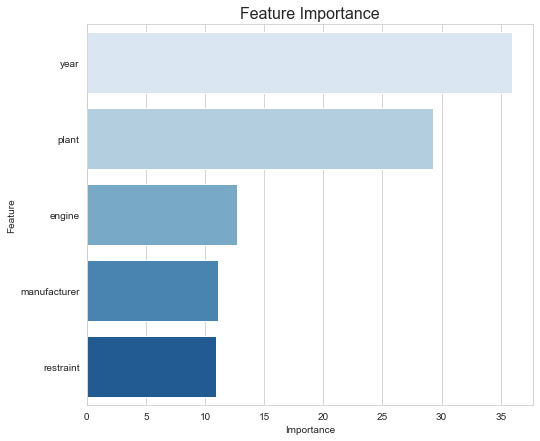

Average score: 3048.28
CPU times: user 1min 58s, sys: 11.7 s, total: 2min 10s
Wall time: 24.7 s


In [42]:
%%time
pipeline_cat = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', CatBoostRegressor(verbose=0))
])

# Оценка качества модели с кросс-валидацией
scores_cat = cross_val_score(pipeline_cat, 
                             X_train, y_train, 
                             cv=5, 
                             scoring='neg_root_mean_squared_error')

pipeline_cat.fit(X_train, y_train)

# Важность признаков
feature_importance(pipeline_cat, X_train)
print(f'Average score: {-scores_cat.mean():.2f}')

Топ-3 признака для **CatBoost**:
- год
- завод производитель
- двигатель

*Контрольный знак (check) находится у отметки .1*

### XGBRegressor

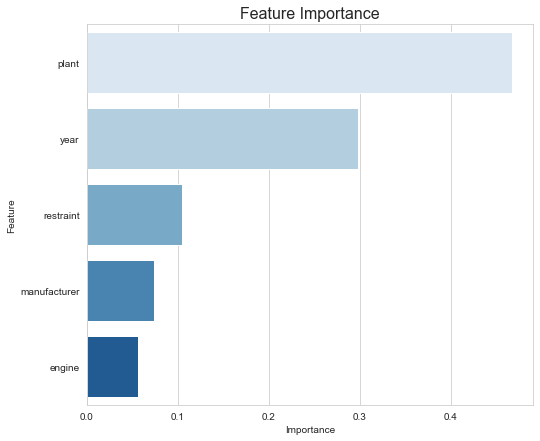

Average score: 3048.51
CPU times: user 16.8 s, sys: 1.78 s, total: 18.6 s
Wall time: 2.87 s


In [43]:
%%time

pipeline_xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(objective='reg:squarederror', verbosity=0))
])

# Оценка качества модели с кросс-валидацией
scores_xgb = cross_val_score(pipeline_xgb, 
                             X_train, y_train, 
                             cv=5, 
                             scoring='neg_root_mean_squared_error')

pipeline_xgb.fit(X_train, y_train)

# Важность признаков
feature_importance(pipeline_xgb, X_train)

print(f'Average score: {-scores_xgb.mean():.2f}')

Топ-3 признака для **DecisionTree**:
- завод производитель
- год
- ремни, тормоза, грузоподъемность у траков

*Контрольный знак находится у отметки 0*

### Ridge

In [44]:
%%time

pipeline_ridge = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge(solver='auto'))
])

# Оценка качества модели с кросс-валидацией
scores_ridge = cross_val_score(pipeline_ridge, 
                         X_train, y_train, 
                         cv=5, 
                         scoring='neg_root_mean_squared_error')

print(f'Average score: {-scores_ridge.mean():.2f}')

Average score: 6214.43
CPU times: user 476 ms, sys: 171 ms, total: 647 ms
Wall time: 197 ms


Алгорит Ridge не поддерживает функцию Feature importance

# TEST

In [45]:
y_pred = pipeline_cat.predict(X_test)

# Вычисление RMSE
rmse = root_mean_squared_error(y_test, y_pred)

# Вывод результатов
print(f'RMSE: {rmse:.2f}')

RMSE: 3494.66


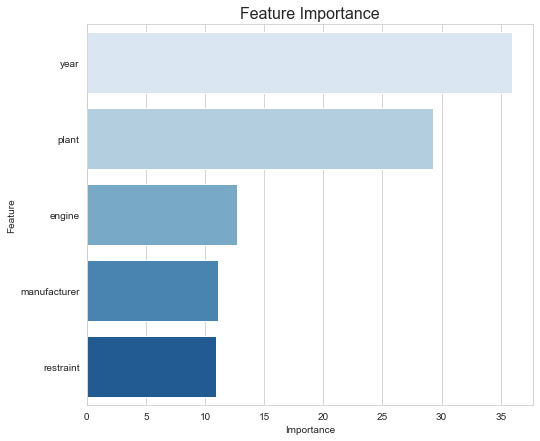

In [46]:
feature_importance(pipeline_cat, X_test)

По итогу:
- Год выпуска машины
- Завод производитель
- Двигатель 

Итоговые признаки вполне соответствуют факторам влияющим на прайс, остальные два признака находятся выше отметки 10 

Так как разница истинных значений и предсказаний немаленькая, не лишним будет визуализировать их распределение 

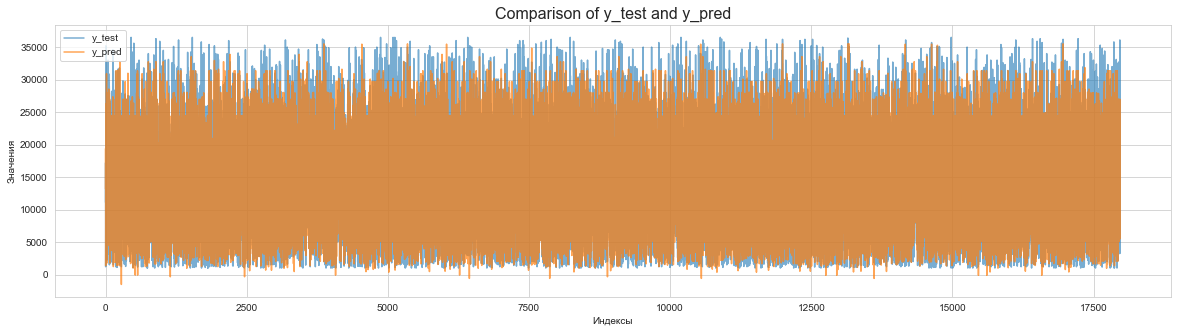

In [47]:
plt.figure(figsize=(20, 5))

plt.plot(range(len(y_test)), y_test, label='y_test', alpha=.6)
plt.plot(range(len(y_pred)), y_pred, label='y_pred', alpha=.7)

plt.title('Comparison of y_test and y_pred', fontsize=16)
plt.xlabel('Индексы')
plt.ylabel('Значения')
plt.legend()
plt.show()


Добавим ограничения по оси X и изучим график более наглядно:

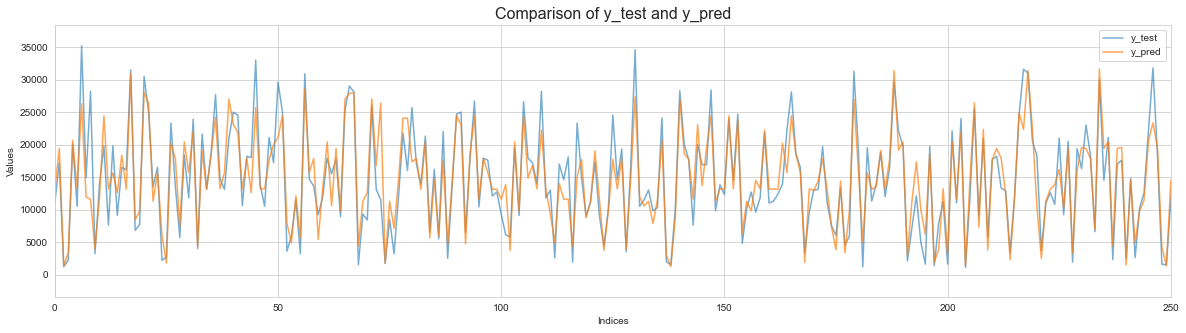

In [48]:
plt.figure(figsize=(20, 5))

plt.plot(range(len(y_test)), y_test, label='y_test', alpha=.6)
plt.plot(range(len(y_pred)), y_pred, label='y_pred', alpha=.7)

plt.title('Comparison of y_test and y_pred', fontsize=16)
plt.xlabel('Indices')
plt.ylabel('Values')
plt.legend()

# Ограничение оси X
plt.xlim(0, 250)
plt.show()


Предсказания в большинстве случаев меньше истинных значений, сравним итоговую модель с фиктивной:

In [49]:
# Обучение фиктивной модели
dummy_model = DummyRegressor(strategy='mean')
dummy_model.fit(X_train, y_train)
dummy_pred = dummy_model.predict(X_test)

# Расчет RMSE для фиктивной модели
rmse_dummy = root_mean_squared_error(y_test, dummy_pred)

# Расчет RMSE для итоговой модели
rmse_beast = root_mean_squared_error(y_test, y_pred)

print(f'RMSE фиктивной модели: {rmse_dummy:.2f}')
print(f'RMSE итоговой модели: {rmse_beast:.2f}')


RMSE фиктивной модели: 7844.31
RMSE итоговой модели: 3494.66


RMSE итоговой модели значительно ниже, что говорит о том, что модель действительно извлекает информацию из данных и делает более точные прогнозы, чем просто предсказание среднего значения.
Исходя из этих наблюдений, можно сделать вывод, что модель хорошо обобщает данные и не переобучена. Однако, как всегда, стоит провести дополнительный анализ и оценку модели, возможно, используя другие метрики или методы валидации, чтобы более точно оценить ее качество.

# Отчет 

**Задача:** извлечь из текстового файла, содержащего VIN-коды машин Ford, необходимые признаки и использовать их для обучения модели.

**Цель проекта:** предсказание цены автомобиля по VIN-коду

**Метрика:** RMSE

Проделанные шаги:
1. Загрузка необходимых библиотек и данных:
   - произведен импорт библиотек
   - заданы параметры отображения
   - заданы значения констант
   - чтение текстового файла
2. Парсинг:
   - определены разрешенные символы
   - скомпилирован шаблон американского VIN формата
   - DataFrame
   - разведочный анализ
3. Предварительная обработка данных:
4. EDA:
 - построены следующие графики:
     - распределения цен
     - для категориальных признаков
     - для 10 наиболее и наименее дорогих моделей
     - коэффициент Фай-Фи
 - отобраны признаки для обучения
6. Обучение моделей:
   - DecisionTreeRegressor
   - RandomForestRegressor
   - CatBoostRegressor
   - XGBRegressor
   - Ridge
7. TEST:
   - получено предсказание модели
   - построен график распределения y_test, y_pred
   - сравнение с фиктивной моделью
  
**Размер тестовой выборки:**

```python
test_size=.25
```
**Параметр random_state:**
```python
random_state=654321
```

**Итоговые признаки:**

- **manufacturer** - производитель
- **restraint** - ремни, тормоза, грузоподъемность у траков
- **engine** - двигатель
- **year** - год
- **plant** - завод произвадитель
- **price** - цена авто

**Описание итоговой модели:**
```python
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standard_scaler',
                                                  StandardScaler(),
                                                  Index(['manufacturer', 
                                                         'restraint', 
                                                         'engine', 
                                                         'year', 
                                                         'plant'], dtype='object'))])),
                ('regressor',
                 <catboost.core.CatBoostRegressor object at 0x7f8df9f21400>)])
```

**RMSE:**
```python
RMSE лучшей модели: 3048.28
RMSE итоговой модели: 3494.66
RMSE фиктивной модели: 7844.31
```